# Revenue Leakage and Profitability Analysis in the Hospitality Sector

This notebook analyzes hotel booking data to identify revenue leakage and suggest strategies to improve profitability. We use booking-level data and enrich it using hotel, room, and date dimension tables to create a unified dataset for business insights.


## Step 1: Preparing the Data for Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# FACT TABLE
bookings = pd.read_csv("fact_bookings.csv")

# DIMENSION TABLES
hotels = pd.read_csv("dim_hotels.csv")
rooms = pd.read_csv("dim_rooms.csv")
dates = pd.read_csv("dim_date.csv")


## Load Datasets

We load the fact table and all dimension tables into pandas DataFrames.
- `fact_bookings.csv` – main transactional data
- `dim_hotels.csv` – hotel names, cities, categories
- `dim_rooms.csv` – room type mapping
- `dim_date.csv` – calendar features for time-based analysis

In [3]:
bookings = bookings.merge(hotels, on='property_id', how='left')


In [4]:
bookings = bookings.merge(rooms, left_on='room_category', right_on='room_id', how='left')
bookings.rename(columns={'room_class': 'room_type'}, inplace=True)
bookings.drop(columns=['room_id'], inplace=True)


In [5]:
# Convert to date only
bookings['booking_date'] = pd.to_datetime(bookings['booking_date']).dt.date
dates['date'] = pd.to_datetime(dates['date'], format='%d-%b-%y', errors='coerce').dt.date

# Merge
bookings = bookings.merge(
    dates[['date', 'mmm yy', 'week no', 'day_type']],
    left_on='booking_date',
    right_on='date',
    how='left'
)
bookings.drop(columns=['date'], inplace=True)

# Optional: Filter out unmatched rows
bookings = bookings[bookings['mmm yy'].notnull()]


In [6]:
print(bookings.info())
print(bookings.head())


<class 'pandas.core.frame.DataFrame'>
Index: 128874 entries, 5 to 134589
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   booking_id         128874 non-null  object 
 1   property_id        128874 non-null  int64  
 2   booking_date       128874 non-null  object 
 3   check_in_date      128874 non-null  object 
 4   checkout_date      128874 non-null  object 
 5   no_guests          128874 non-null  int64  
 6   room_category      128874 non-null  object 
 7   booking_platform   128874 non-null  object 
 8   ratings_given      54292 non-null   float64
 9   booking_status     128874 non-null  object 
 10  revenue_generated  128874 non-null  int64  
 11  revenue_realized   128874 non-null  int64  
 12  property_name      128874 non-null  object 
 13  category           128874 non-null  object 
 14  city               128874 non-null  object 
 15  room_type          128874 non-null  object 
 16  mmm yy 

## Data Enrichment: Merging Dimension Tables

To create a fully unified and analysis-ready dataset, we merged the following dimension tables into our primary fact table (`fact_bookings.csv`). Each merge added meaningful context to enhance our insights.

### 1. Merge with `dim_hotels.csv`
- **Join key**: `property_id`
- **Added columns**: `property_name`, `category` (hotel type), `city`
- **Purpose**: Enables location-based and hotel-level analysis (e.g., revenue by city or category)

### 2. Merge with `dim_rooms.csv`
- **Join key**: `room_category` (fact) → `room_id` (dim)
- **Added column**: `room_class` (renamed as `room_type`)
- **Purpose**: Enables analysis of profitability and leakage by room type (Standard, Elite, etc.)

### 3. Merge with `dim_date.csv`
- **Join key**: `booking_date` (fact) → `date` (dim)
- **Date format**: Converted both columns to plain `date` (not datetime) before merging
- **Added columns**: `mmm yy` (month), `week no`, `day_type` (weekend/weekday)
- **Purpose**: Enables time-based trend analysis (e.g., revenue by month or weekend)

After all merges, our dataset has:
- Detailed transaction info
- Hotel & room context
- Temporal features

This enriched dataset allows for deep business insights and supports effective revenue leakage analysis.


In [7]:
print("Duplicate rows:", bookings.duplicated().sum())


Duplicate rows: 0


In [8]:
print("Nulls in each column:")
print(bookings.isnull().sum().sort_values(ascending=False))


Nulls in each column:
ratings_given        74582
property_id              0
booking_id               0
booking_date             0
check_in_date            0
no_guests                0
checkout_date            0
room_category            0
booking_platform         0
booking_status           0
revenue_generated        0
revenue_realized         0
property_name            0
category                 0
city                     0
room_type                0
mmm yy                   0
week no                  0
day_type                 0
dtype: int64


In [9]:
null_percentage = bookings['ratings_given'].isnull().mean() * 100
print(f"Missing ratings: {null_percentage:.2f}%")


Missing ratings: 57.87%


In [10]:
print("Final shape:", bookings.shape)


Final shape: (128874, 19)


## Clean and Validate the Final Dataset

We check for:
- Duplicates
- Null values
- Column consistency
This ensures our dataset is clean and ready for analysis.



In [11]:
bookings.to_csv("final_bookings_cleaned.csv", index=False)


## Step 2: Revenue Leakage Analysis

In [12]:
bookings['revenue_loss'] = bookings['revenue_generated'] - bookings['revenue_realized']


In [13]:
bookings[['revenue_generated', 'revenue_realized', 'revenue_loss']].head()


,revenue_generated,revenue_realized,revenue_loss
5,9100,9100,0
25,12600,12600,0
64,11050,11050,0
79,15300,15300,0
81,18360,7344,11016


In [14]:
loss_count = (bookings['revenue_loss'] > 0).sum()
print(f"Bookings with revenue loss: {loss_count}")


Bookings with revenue loss: 31934


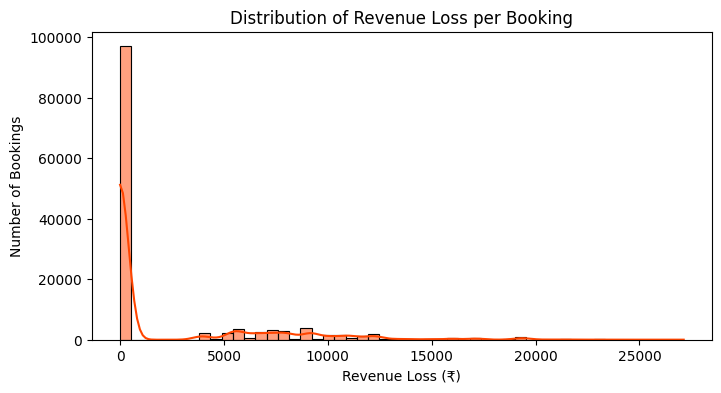

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(bookings['revenue_loss'], bins=50, kde=True, color='orangered')
plt.title("Distribution of Revenue Loss per Booking")
plt.xlabel("Revenue Loss (₹)")
plt.ylabel("Number of Bookings")
plt.show()


## Revenue Loss per Booking
We added a new column to calculate revenue loss per booking using the formula:  
`revenue_loss = revenue_generated - revenue_realized`

We saw that about 25% of bookings had some loss. 
Most losses were small, but a few bookings had very high loss, 
which could be due to booking failures or policy issues.
We also plotted a histogram of `revenue_loss` to understand how it is distributed.



In [16]:
total_generated = bookings['revenue_generated'].sum()
total_realized = bookings['revenue_realized'].sum()
total_loss = bookings['revenue_loss'].sum()


In [17]:
leakage_percent = (total_loss / total_generated) * 100
print(f"Total revenue loss: ₹{total_loss}")
print(f"Percentage of revenue lost: {leakage_percent:.2f}%")


Total revenue loss: ₹285496455
Percentage of revenue lost: 14.85%


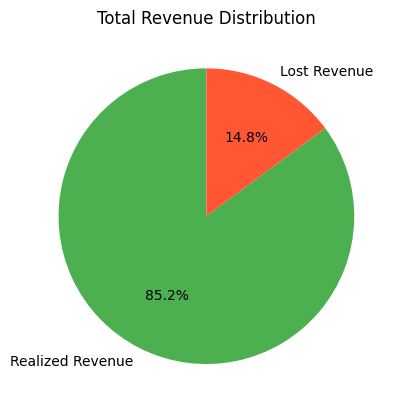

In [18]:
import matplotlib.pyplot as plt

plt.pie(
    [total_realized, total_loss],
    labels=['Realized Revenue', 'Lost Revenue'],
    autopct='%1.1f%%',
    colors=['#4CAF50', '#FF5733'],
    startangle=90
)
plt.title("Total Revenue Distribution")
plt.show()


## Total Revenue Leakage
We calculated the total revenue generated, revenue realized, and the total revenue lost across all bookings.

**Key Result:**
- Total revenue loss: ₹28.55 Crores
- Loss percentage: 14.85%
This shows that a significant portion of expected revenue is not realized across the system.

In [19]:
platform_stats = bookings.groupby('booking_platform').agg({
    'revenue_generated': 'sum',
    'revenue_realized': 'sum',
    'revenue_loss': 'sum'
}).reset_index()


In [20]:
platform_stats['leakage_percent'] = (platform_stats['revenue_loss'] / platform_stats['revenue_generated']) * 100


In [21]:
platform_stats = platform_stats.sort_values(by='leakage_percent', ascending=False)
print(platform_stats)


  booking_platform  revenue_generated  revenue_realized  revenue_loss  \
4     makeyourtrip          384211545         326297685      57913860   
2          journey          115292435          98036498      17255937   
1    direct online          190817760         162425889      28391871   
6         tripster          138028580         117554645      20473935   
5           others          786756370         670153069     116603301   
0   direct offline           97091425          82801660      14289765   
3          logtrip          210456200         179888414      30567786   

   leakage_percent  
4        15.073430  
2        14.967103  
1        14.879051  
6        14.833113  
5        14.820764  
0        14.717845  
3        14.524536  


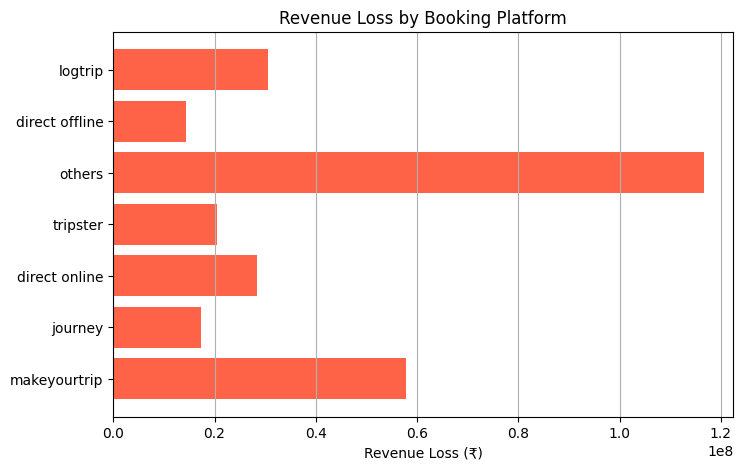

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(platform_stats['booking_platform'], platform_stats['revenue_loss'], color='tomato')
plt.xlabel("Revenue Loss (₹)")
plt.title("Revenue Loss by Booking Platform")
plt.grid(axis='x')
plt.show()


## Revenue Leakage by Booking Platform
We grouped bookings by `booking_platform` to compare total revenue loss and leakage percentages.

**Key Findings:**
- All platforms had a similar leakage % (~15%)
- However, total revenue loss varied a lot depending on booking volume
- The ‘others’ group showed the highest total loss
We visualized this using a horizontal bar chart.



In [23]:
bookings.to_csv("bookings_with_analysis.csv", index=False)


In [24]:
# Drop rows where ratings_given is missing
ratings_data = bookings.dropna(subset=['ratings_given'])


In [25]:
# Calculate correlation between ratings and revenue loss
correlation = ratings_data['ratings_given'].corr(ratings_data['revenue_loss'])
print(f"Correlation between ratings and revenue loss: {correlation:.4f}")


Correlation between ratings and revenue loss: nan


c:\Users\shrey\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3063: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\shrey\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3064: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


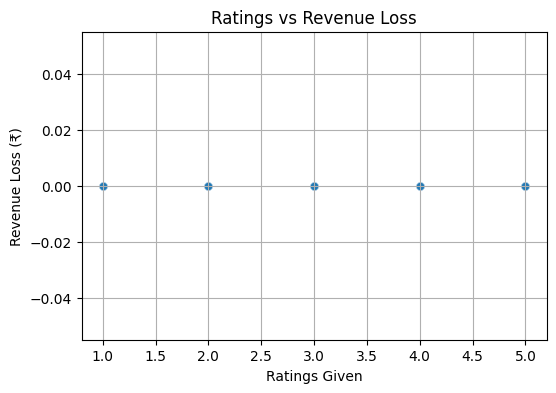

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.scatterplot(x='ratings_given', y='revenue_loss', data=ratings_data, alpha=0.3)
plt.title("Ratings vs Revenue Loss")
plt.xlabel("Ratings Given")
plt.ylabel("Revenue Loss (₹)")
plt.grid(True)
plt.show()


## Optional Analysis: Correlation Between Ratings and Revenue Loss
We tried to find out if there’s any connection between customer ratings and the amount of revenue lost per booking.

We removed rows that had missing ratings and calculated the correlation between `ratings_given` and `revenue_loss`. 
However, most of the rows with ratings had no revenue loss, so there wasn’t enough variation in the data.
As a result, the correlation value was undefined, and the scatterplot showed no real pattern.

### What We Can Take From This:
This tells us that bookings with revenue loss usually don’t have a rating — possibly because the booking was canceled or not completed. So even though we didn’t get a numeric correlation, we still learn that missing ratings could signal a lost or broken customer experience.


In [27]:
ratings_data.to_csv("bookings_with_ratings_only.csv", index=False)


## Summary: Possible Reasons Behind Revenue Loss
While analyzing revenue loss, we need to consider that multiple factors could be contributing to it — not just cancellations.

Based on real-world scenarios, here are other possible causes:
- **Platform commissions**: Some platforms deduct a fixed fee from each booking.
- **Discounts or coupons**: Late-stage discounts can reduce realized revenue.
- **No-shows without penalties**: If the guest doesn’t show up and there’s no charge, the hotel earns nothing.
- **Partial stays or early check-outs**: If someone leaves early and gets refunded.
- **Payment failures or reversals**: Sometimes the amount generated may not reach the hotel due to failed transactions or chargebacks.

Since our dataset only shows the numbers (generated vs realized), we cannot know the exact reason in each case. But these possibilities are important to remember when drawing conclusions and giving suggestions.
